# **Hate Speech Detector**

## **Model "german-sentiment-bert"**

## 1. Load and prepare data

In [1]:
import pandas as pd
from google.colab import files
import io
uploaded = files.upload()

Saving hatespeech.csv to hatespeech.csv


In [2]:
df = pd.read_csv(io.BytesIO(uploaded['hatespeech.csv']),lineterminator='\n')

In [3]:
df.drop('Unnamed: 0',inplace=True,axis=1)

In [21]:
#shuffle data
df = df.sample(frac=1).reset_index(drop=True)

In [22]:
df.head()

,message,HateSpeech
0,Langsam werden immer mehr Politiker wach dann ...,0
1,Hier hagelt es gerade. Habe der Kröte mal die ...,0
2,Ich als Deutsche möchte mich keinem Islam anpa...,0
3,Kann Mann besser sagen 57 Länder/Staaten die ...,1
4,Wenn der DEUTSCHE BÜRGER sich erstmal wieder s...,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19379 entries, 0 to 19378
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   message     19379 non-null  object
 1   HateSpeech  19379 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 302.9+ KB


In [7]:
df.shape

(19379, 2)

In [8]:
df['HateSpeech'].value_counts()

0    15138
1     4241
Name: HateSpeech, dtype: int64

## 2. Deep Learning

## 2.1. Install Simple Transformers library

In [9]:
# install simpletransformers
!pip install simpletransformers

# check installed version
!pip freeze | grep simpletransformers
# simpletransformers==0.28.2

simpletransformers==0.63.3


## 2.2. Select a pre-trained language model

Simple Transformers library is based on the Transformers library from HuggingFace. This enables to use every pre-trained model provided in the Transformers library and all community-uploaded models. For a list of models refer to https://huggingface.co/models.

## 2.3. Train Test Split


In [23]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.20)

print('train shape: ',train_df.shape)
print('test shape: ',test_df.shape)

train shape:  (15503, 2)
test shape:  (3876, 2)


## 2.4. Load pre-trained model

https://huggingface.co/oliverguhr/german-sentiment-bert

In [24]:
from simpletransformers.classification import ClassificationModel

# define hyperparameter
train_args ={"reprocess_input_data": True,
             "overwrite_output_dir": True,
             "fp16":False,
             "threshold": 0.6,
             "num_train_epochs": 10,
             'train_batch_size': 100,
             'use_early_stopping': True,
             'optimizer': 'AdamW',
             'early_stopping_metric': 'eval_loss' 
             }

# Create a ClassificationModel
german_sentiment_bert_m = ClassificationModel(
    "bert", "oliverguhr/german-sentiment-bert",
    num_labels=2,
    weight=[0.5, 5],
    args=train_args,
    ignore_mismatched_sizes=True
)

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at oliverguhr/german-sentiment-bert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/161 [00:00<?, ?B/s]

## 2.5. Train model

In [25]:
# Train the model
german_sentiment_bert_m.train_model(train_df)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/15503 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

(1560, 0.21022173512774783)

## 3. Evaluation

## 3.1. Results

In [27]:
from sklearn.metrics import f1_score, accuracy_score

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
result, model_outputs, wrong_predictions = german_sentiment_bert_m.eval_model(test_df, f1=f1_multiclass, acc=accuracy_score)

result

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/3876 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/485 [00:00<?, ?it/s]

{'mcc': 0.4275533805131535,
 'tp': 431,
 'tn': 2717,
 'fp': 296,
 'fn': 432,
 'auroc': 0.7639446908125817,
 'auprc': 0.5536349330638302,
 'f1': 0.8121775025799794,
 'acc': 0.8121775025799793,
 'eval_loss': 1.6210181832428752}

## 3.2. Confusion Matrix

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt 
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'True lables'
    cm.columns.name = 'Predicted labels'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [29]:
lst = []
for arr in model_outputs:
    lst.append(np.argmax(arr))

true = test_df['HateSpeech'].tolist()
predicted = lst

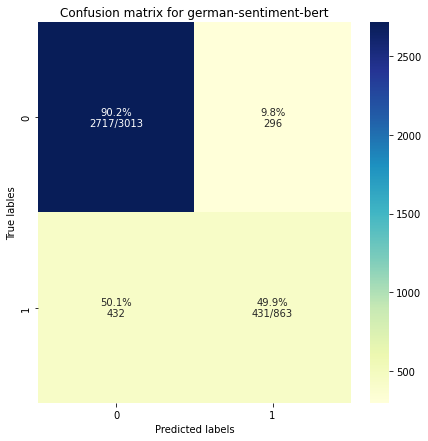

In [30]:
plot_cm(true, predicted, 'Confusion matrix for german-sentiment-bert', figsize=(7,7))

## 3.3. Classification report

In [31]:
from sklearn import metrics
print(metrics.classification_report(true, predicted, digits=3))

              precision    recall  f1-score   support

           0      0.863     0.902     0.882      3013
           1      0.593     0.499     0.542       863

    accuracy                          0.812      3876
   macro avg      0.728     0.701     0.712      3876
weighted avg      0.803     0.812     0.806      3876



## 4. Predictions

In [32]:
class_list = ['Other','Hate Speech']

test_tweet = 'Muslime entwickeln sich langsam aber stetig zu einem bösartigen Tumor der dringend entfernt werden muss'

predictions, raw_outputs = german_sentiment_bert_m.predict([test_tweet])

print(class_list[predictions[0]])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Hate Speech


In [33]:
class_list = ['Other','Hate Speech']

test_tweet = 'Während in Glasgow verhandelt wird, blockiert eine kleine Gruppe von Aktivisten die Straßen um London.'

predictions, raw_outputs = german_sentiment_bert_m.predict([test_tweet])

print(class_list[predictions[0]])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Other
